<a href="https://colab.research.google.com/github/KollexTheAnalyst/Electricity-Forecast/blob/main/Combined_Model_GRU1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
MT_deterministic_data <- read.csv("mid_deterministic_data.csv")

In [ ]:
# make a training set until end of 2018
mid_training = MT_deterministic_data[1:2190,]

In [ ]:
combination_mid_final <-read.csv("midterm_combinations_final_trimmed.csv")


In [ ]:
variables_mid <- colnames(combination_mid_final[4,2:22])[complete.cases(t(combination_mid_final[4,2:22]))]

In [ ]:
## add month variables step-wise
variables_midterm_month=colnames(MT_deterministic_data[,c(18:28)])

In [ ]:
month_formula <- as.formula(paste("mid_load", paste(variables_midterm_month, collapse = " + "),
                               sep = " ~ "))


In [ ]:
model_month <- lm(month_formula, data= mid_training,na.action="na.fail")


In [ ]:
# Install the MuMIn package
install.packages("MuMIn")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘insight’




In [ ]:
# Load the MuMIn package
library(MuMIn)

In [ ]:
# dredge() method is just a quick way to get the logical matrix, should go very fast
combinations_month <- dredge(model_month,trace = T)

Fixed term is "(Intercept)"



0 : lm(formula = mid_load ~ 1, data = mid_training, na.action = "na.fail")
1 : lm(formula = mid_load ~ apr + 1, data = mid_training, na.action = "na.fail")
2 : lm(formula = mid_load ~ aug + 1, data = mid_training, na.action = "na.fail")
3 : lm(formula = mid_load ~ apr + aug + 1, data = mid_training, na.action = "na.fail")
4 : lm(formula = mid_load ~ feb + 1, data = mid_training, na.action = "na.fail")
5 : lm(formula = mid_load ~ apr + feb + 1, data = mid_training, na.action = "na.fail")
6 : lm(formula = mid_load ~ aug + feb + 1, data = mid_training, na.action = "na.fail")
7 : lm(formula = mid_load ~ apr + aug + feb + 1, data = mid_training, 
    na.action = "na.fail")
8 : lm(formula = mid_load ~ jan + 1, data = mid_training, na.action = "na.fail")
9 : lm(formula = mid_load ~ apr + jan + 1, data = mid_training, na.action = "na.fail")
10 : lm(formula = mid_load ~ aug + jan + 1, data = mid_training, na.action = "na.fail")
11 : lm(formula = mid_load ~ apr + aug + jan + 1, data = mid_traini

In [ ]:
# initiate a data frame to save the model AICc
rank_df <- as.data.frame(matrix(nrow=nrow(combinations_month),ncol = 2))
colnames(rank_df)<- c("AICc","model_no")


In [ ]:
# calculate all combinations with month added and save AICc

for (i in 1:nrow(combinations_month)){
variables_month=colnames(combinations_month[i,2:12])[complete.cases(t(combinations_month[i,2:12]))]
variables_all= c(variables_mid,variables_month)
formula_all <- as.formula(paste("mid_load", paste(variables_all, collapse = " + "),
                                  sep = " ~ "))
model_all <- lm(formula_all, data= mid_training,na.action="na.fail")

rank_df$AICc[i] <- AICc(model_all)
rank_df$model_no[i] <- i
}

In [ ]:
# look at best models
best_models <- order(rank_df$AICc)

variables_best_month=colnames(combinations_month[best_models[1],2:12])[complete.cases(t(combinations_month[best_models[1],2:12]))]
variables_final= c(variables_mid,variables_best_month)
formula_final <- as.formula(paste("mid_load", paste(variables_final, collapse = " + "),
                                sep = " ~ "))
model_final <- lm(formula_final, data= mid_training,na.action="na.fail")
save(model_final,file = "model_final_new.Rdata")

In [ ]:
MT <- predict(model_final, MT_deterministic_data, interval = "confidence")

In [ ]:
residuals <- MT_deterministic_data$mid_load - MT[,1]
MT_deterministic_data$target_residuals <- residuals
MT_deterministic_data$lm_pred <- MT[,1]

write.csv(MT_deterministic_data,"midterm_det_new.csv", row.names = F )

In [ ]:
##Load Prediction results from the ML-GRU model

GRU_result1 <- read.csv("New_GRU_result_datasets.csv")

In [ ]:
###### Load machine learning GRU results ########
## Note: Code for the LSTM is proprietary owned by the DLR Oldenburg, so only the output
## of the model can be made publicly available

MT_deterministic_data$gru <- 0
MT_deterministic_data$gru[2191:2920] <- GRU_result1$Prediction

write.csv(MT_deterministic_data, "midterm_det_new_1.csv",row.names = F)

In [ ]:
###### ARIMA calculation ########
## Note: this takes very long and is already calculated, results are stored
##       in "./Data/mid_ARIMA_results.csv"
MT_deterministic_data1 <- read.csv("midterm_det_new_1.csv")

In [ ]:
###### ARIMA calculation ########
##Arima result gotten from existing work (github), so we skipped recalculating it

##load the results:
test_df <- read.csv("mid_ARIMA_results.csv")

test_df<- test_df[is.na(test_df$sum_all)==F,]
p_order <- test_df$p[test_df$sum_all==min(test_df$sum_all)]
q_order <- test_df$q[test_df$sum_all==min(test_df$sum_all)]

In [ ]:
##To use the ARIMA funtion, we have to install;
# Install the forecast package
install.packages("forecast")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘quantmod’, ‘fracdiff’, ‘lmtest’, ‘Rcpp’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’




In [ ]:
# Load the forecast package
library(forecast)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [ ]:
library(tseries)

In [ ]:
res <- model_final$residuals

In [ ]:
adf.test(res)
kpss.test(res)
# --> data is non-stationary
# double-check with auto.arima()

starting_model <- auto.arima(res)
checkresiduals(starting_model)
# --> residuals need to be differenced once to become stationary
d=1
diff_res <- diff(res,1)
acf(diff_res)
# last significant lag at t=7  --> max grid search p-oder = 9
pacf(diff_res)
# last significant lat at t=25 --> max grid search q-oder = 27

test_df<- data.frame(matrix(nrow=(9*27),ncol = 5))
colnames(test_df)<- c("AICC","sum_nine","sum_all","p","q")

In [ ]:
## If not calculated load the results:
test_df <- read.csv("mid_ARIMA_results.csv")

test_df<- test_df[is.na(test_df$sum_all)==F,]
p_order <- test_df$p[test_df$sum_all==min(test_df$sum_all)]
q_order <- test_df$q[test_df$sum_all==min(test_df$sum_all)]


best_model_mid <- Arima(res, order = c(p_order, d, q_order))

save(best_model_mid,file="fit1.mid.Rdata")

In [ ]:
# Install the DHARMa package
install.packages("DHARMa")

# Load the DHARMa package
library(DHARMa)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘htmlwidgets’, ‘lazyeval’, ‘crosstalk’, ‘promises’, ‘rbibutils’, ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘later’, ‘foreach’, ‘iterators’, ‘gap.datasets’, ‘plotly’, ‘Rdpack’, ‘shiny’, ‘plyr’, ‘doParallel’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘gap’, ‘ape’, ‘qgam’, ‘lme4’


This is DHARMa 0.4.6. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa')



In [ ]:
### Add linear regressors to ARIMA ----

# First test within-group deviation from uniformity and homogeneity of variances
# of the seasonal regressors with scaled residuals from DHARMa package
simulationOutput <- simulateResiduals(fittedModel = model_final, plot = F)

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.031412, p-value = 0.04914
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.043, p-value = 0.6111
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.04914414 0.61114634

$uniformity$p.value.cor
[1] 0.09828828 0.61114634


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value Pr(>F)
group    1  0.0604 0.8059
      2188               


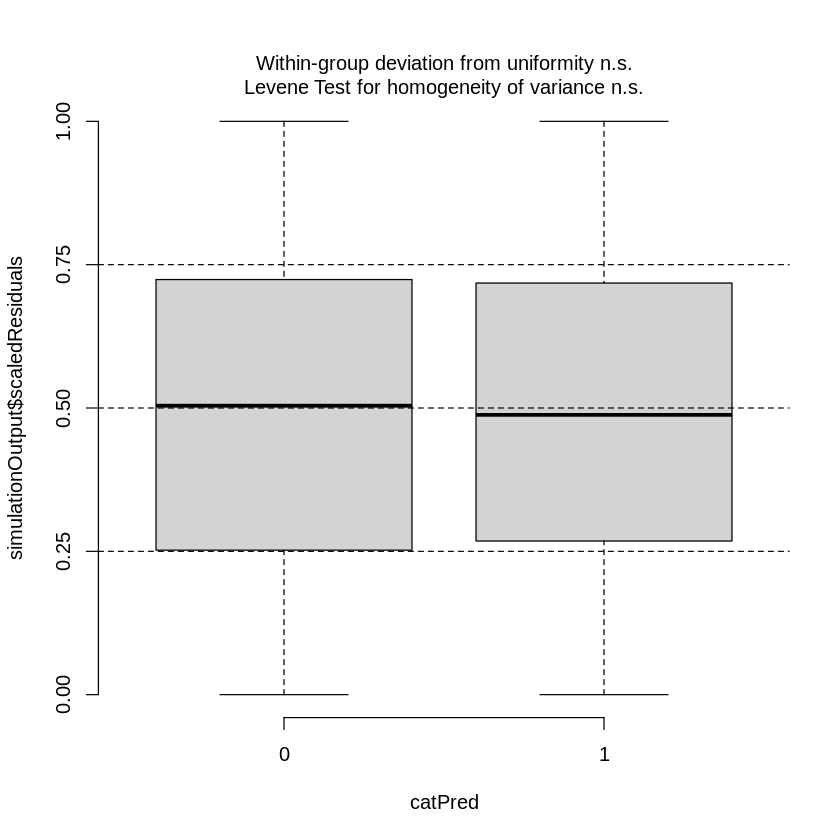

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.031342, p-value = 0.05007
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.065444, p-value = 0.1369
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.05006744 0.13692971

$uniformity$p.value.cor
[1] 0.1001349 0.1369297


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value Pr(>F)
group    1  2.4845 0.1151
      2188               


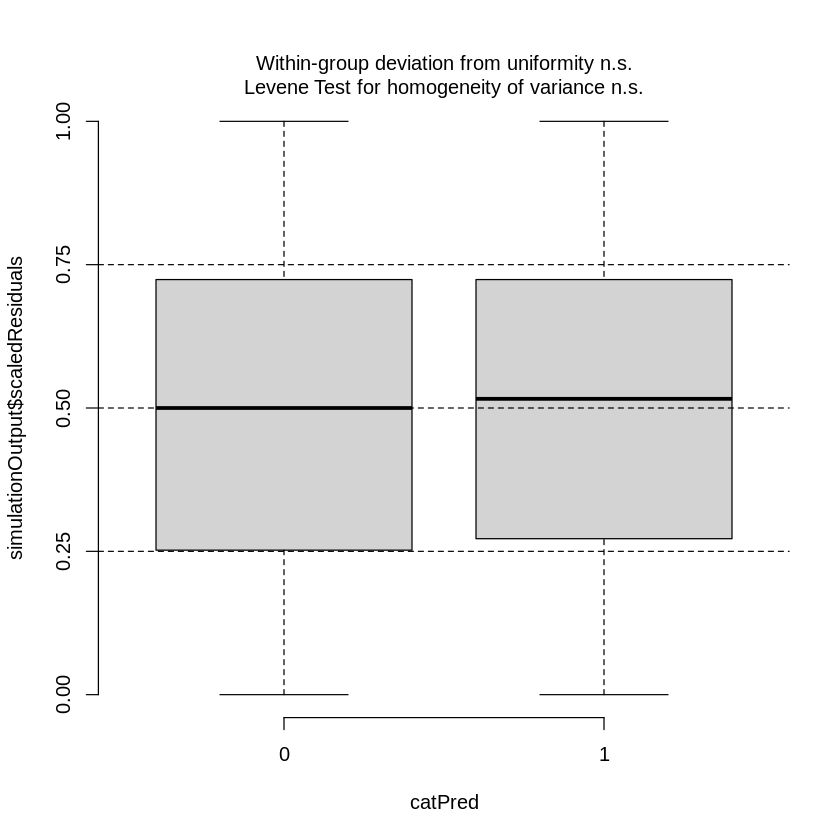

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.031874, p-value = 0.04412
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.039604, p-value = 0.7101
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.04412138 0.71013062

$uniformity$p.value.cor
[1] 0.08824275 0.71013062


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value Pr(>F)
group    1  0.0152  0.902
      2188               


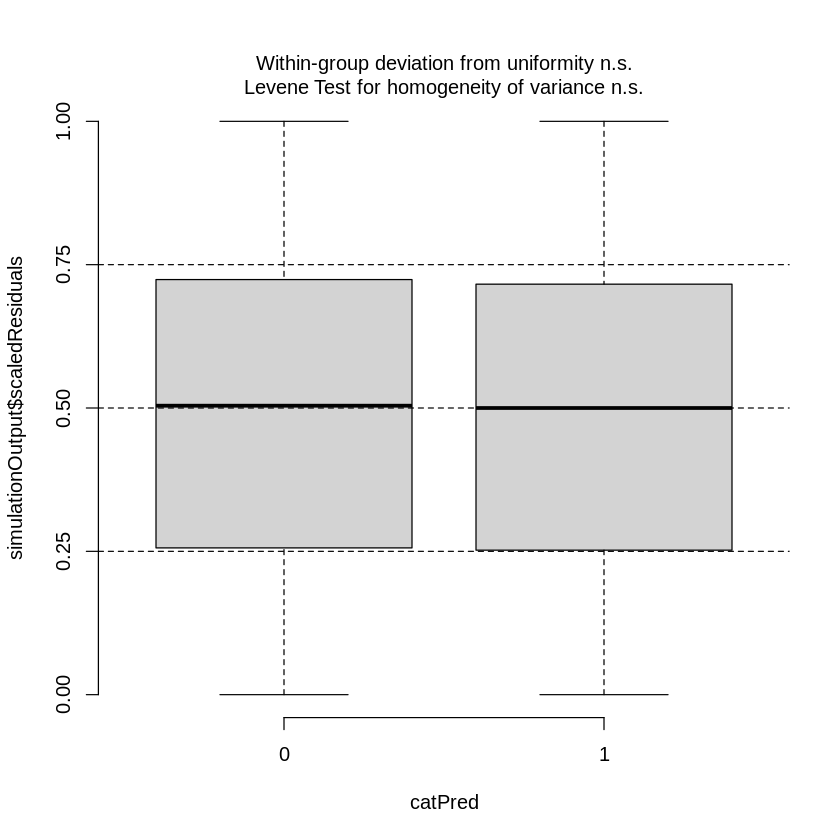

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.032407, p-value = 0.0388
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.035399, p-value = 0.8277
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.03879864 0.82769551

$uniformity$p.value.cor
[1] 0.07759728 0.82769551


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value Pr(>F)
group    1  0.2244 0.6358
      2188               


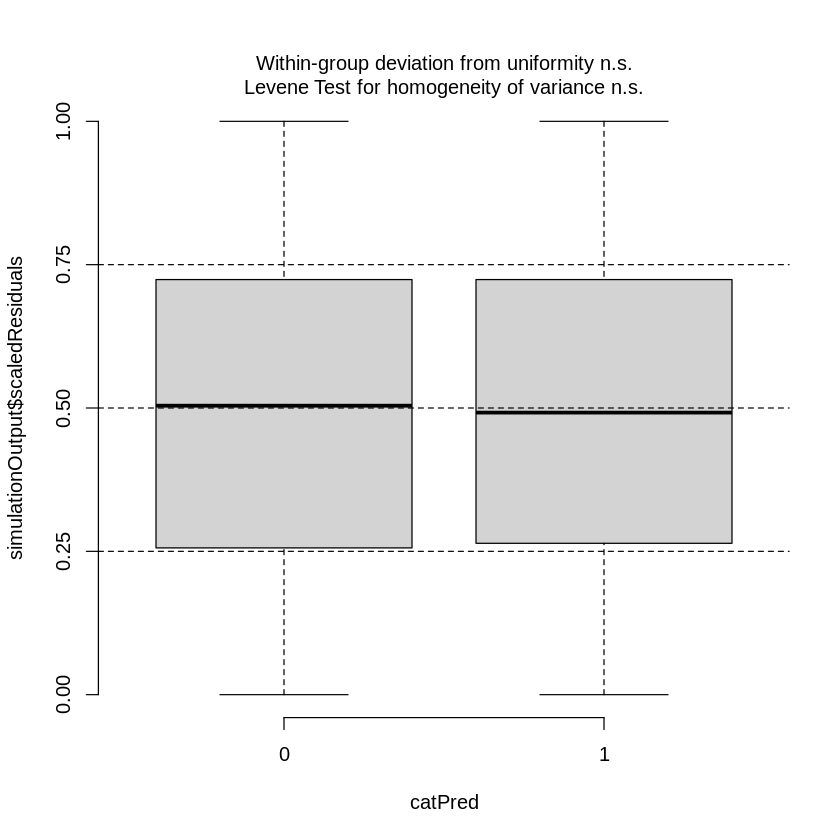

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.033227, p-value = 0.0317
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.041917, p-value = 0.6413
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.03169739 0.64134446

$uniformity$p.value.cor
[1] 0.06339477 0.64134446


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value Pr(>F)
group    1  0.0227 0.8803
      2188               


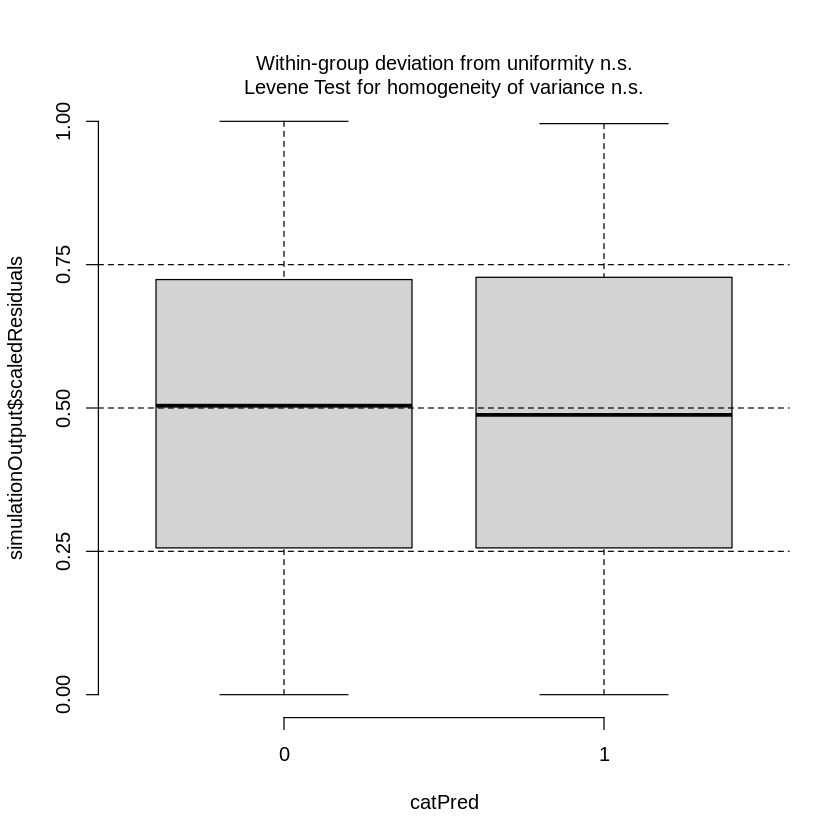

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.038497, p-value = 0.02263
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.027906, p-value = 0.6666
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.02262811 0.66658801

$uniformity$p.value.cor
[1] 0.04525622 0.66658801


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value  Pr(>F)  
group    1  3.5367 0.06016 .
      2188                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


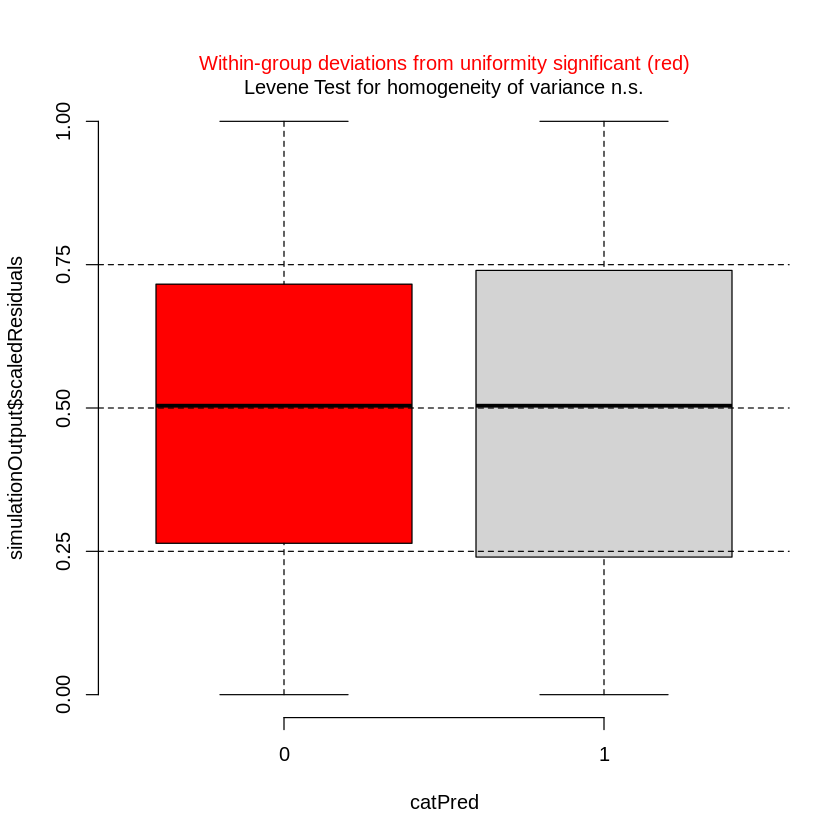

In [ ]:
# test weekdays

testCategorical(simulationOutput, catPred = MT_deterministic_data1$mon[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$tue[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$wed[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$thu[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$sat[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$we[1:2190])

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.045238, p-value = 0.0005482
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.16994, p-value = 4.321e-05
alternative hypothesis: two-sided


$uniformity$p.value
[1] 5.481514e-04 4.320759e-05

$uniformity$p.value.cor
[1] 5.481514e-04 8.641518e-05


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value    Pr(>F)    
group    1  38.813 5.576e-10 ***
      2188                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


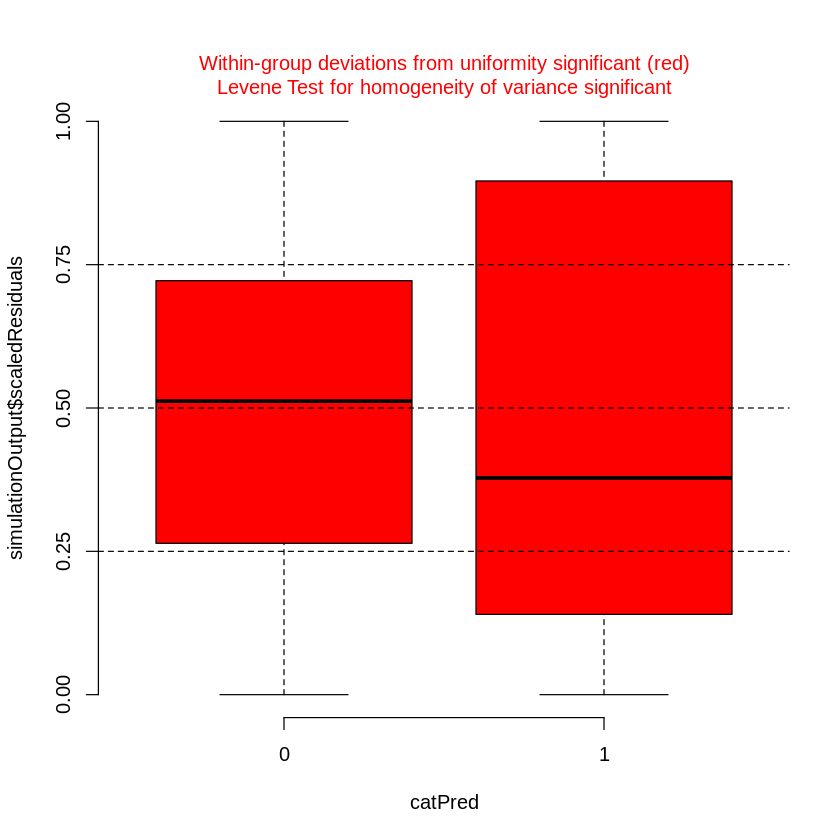

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.04036, p-value = 0.002755
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.15357, p-value = 0.0007237
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.0027552226 0.0007236964

$uniformity$p.value.cor
[1] 0.002755223 0.001447393


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value  Pr(>F)  
group    1  5.0175 0.02519 *
      2188                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


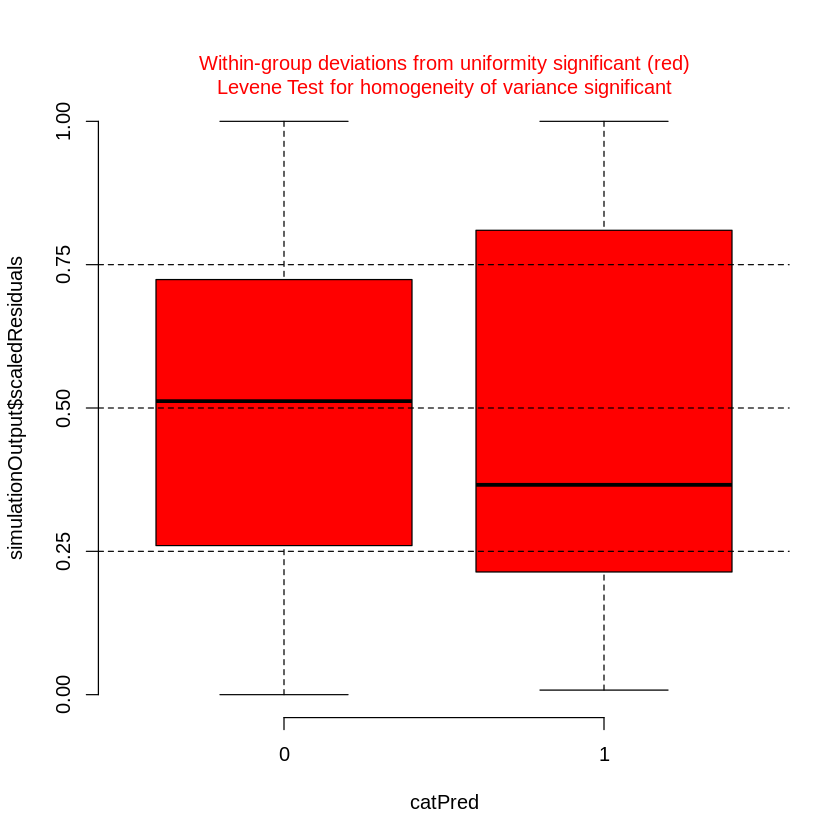

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.035756, p-value = 0.0119
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.072086, p-value = 0.2886
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.01190036 0.28855908

$uniformity$p.value.cor
[1] 0.02380072 0.28855908


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value  Pr(>F)  
group    1  3.9925 0.04583 *
      2188                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


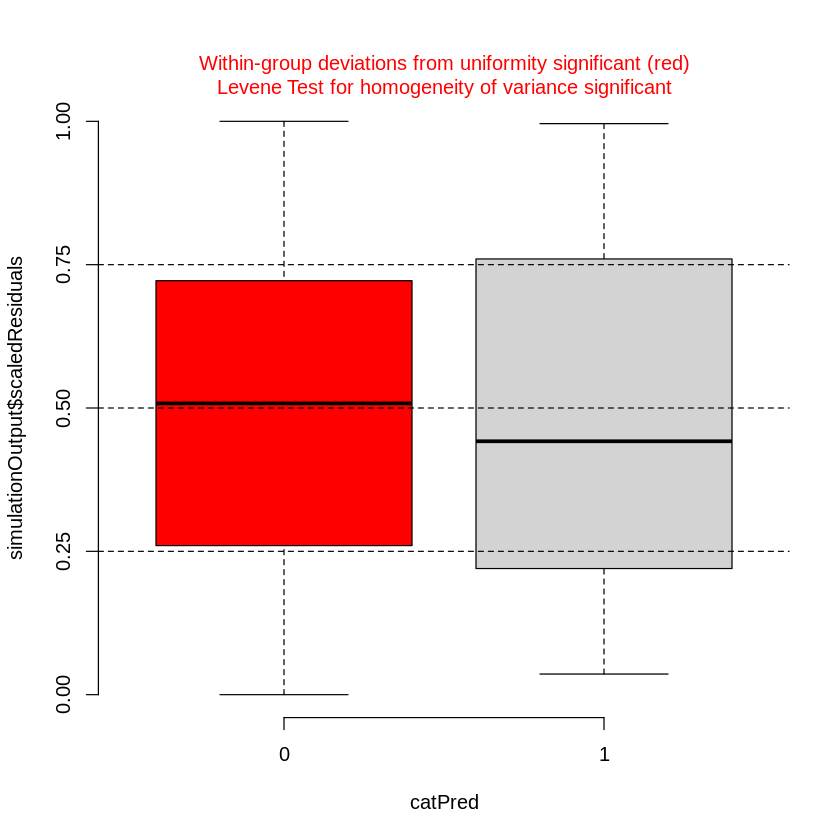

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.035144, p-value = 0.01395
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.081778, p-value = 0.1799
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.01395333 0.17994199

$uniformity$p.value.cor
[1] 0.02790667 0.17994199


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value  Pr(>F)  
group    1  3.6056 0.05772 .
      2188                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


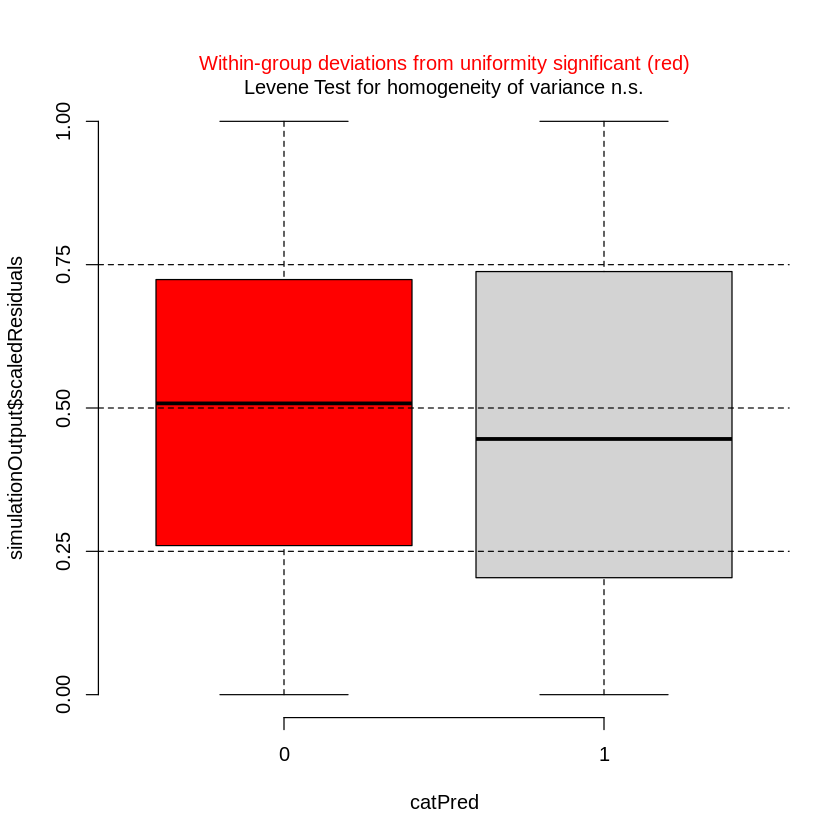

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.031788, p-value = 0.03484
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.074323, p-value = 0.2557
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.0348411 0.2556801

$uniformity$p.value.cor
[1] 0.0696822 0.2556801


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value Pr(>F)
group    1  1.7555 0.1853
      2188               


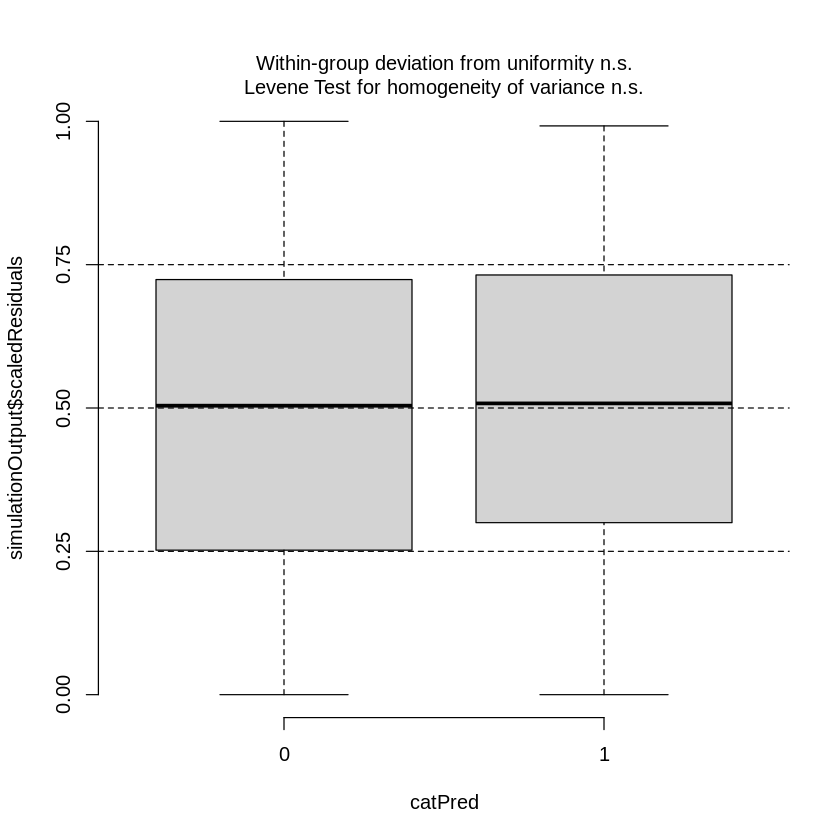

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.025751, p-value = 0.139
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.12244, p-value = 0.009057
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.139044952 0.009057121

$uniformity$p.value.cor
[1] 0.13904495 0.01811424


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value    Pr(>F)    
group    1  37.047 1.358e-09 ***
      2188                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


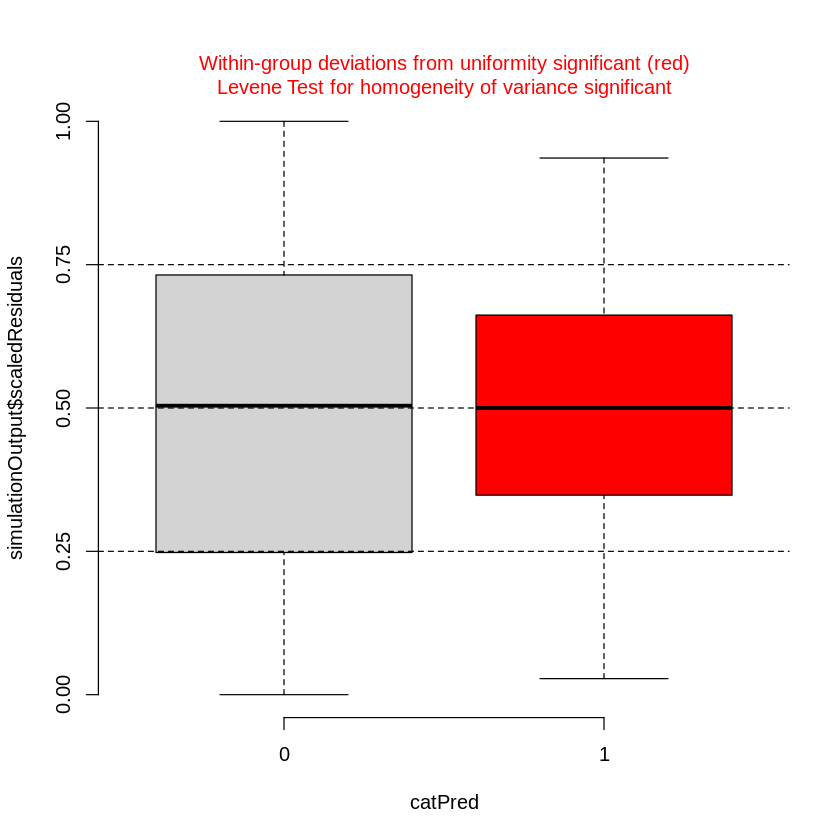

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.021285, p-value = 0.324
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.17798, p-value = 1.526e-05
alternative hypothesis: two-sided


$uniformity$p.value
[1] 3.239939e-01 1.525729e-05

$uniformity$p.value.cor
[1] 3.239939e-01 3.051458e-05


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value    Pr(>F)    
group    1  72.001 < 2.2e-16 ***
      2188                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


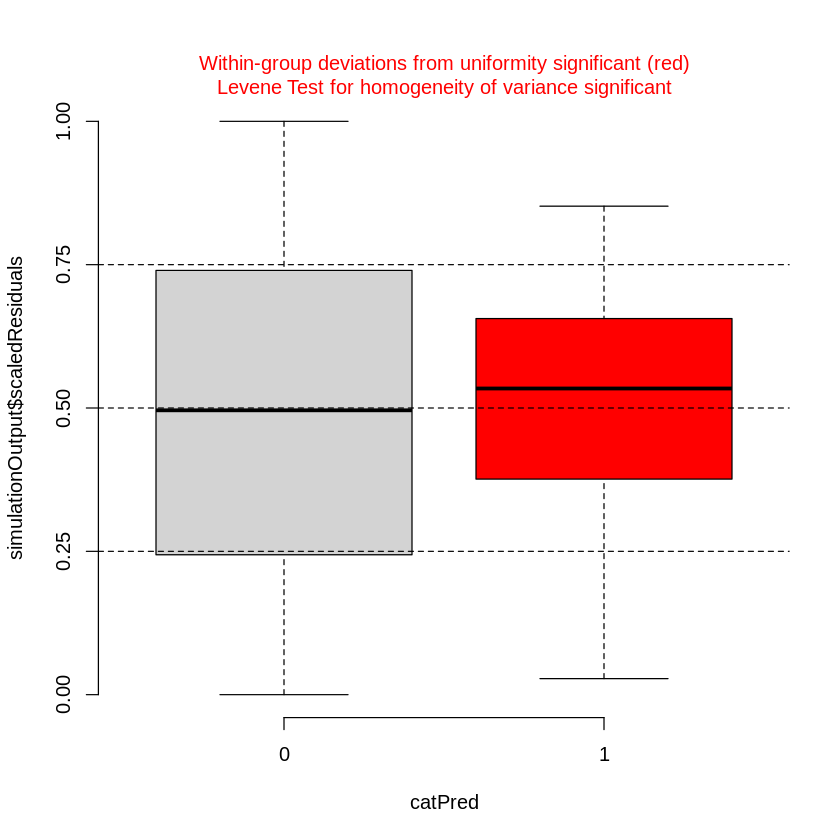

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.02798, p-value = 0.08675
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.11978, p-value = 0.009615
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.086749724 0.009614623

$uniformity$p.value.cor
[1] 0.08674972 0.01922925


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value  Pr(>F)  
group    1   6.368 0.01169 *
      2188                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


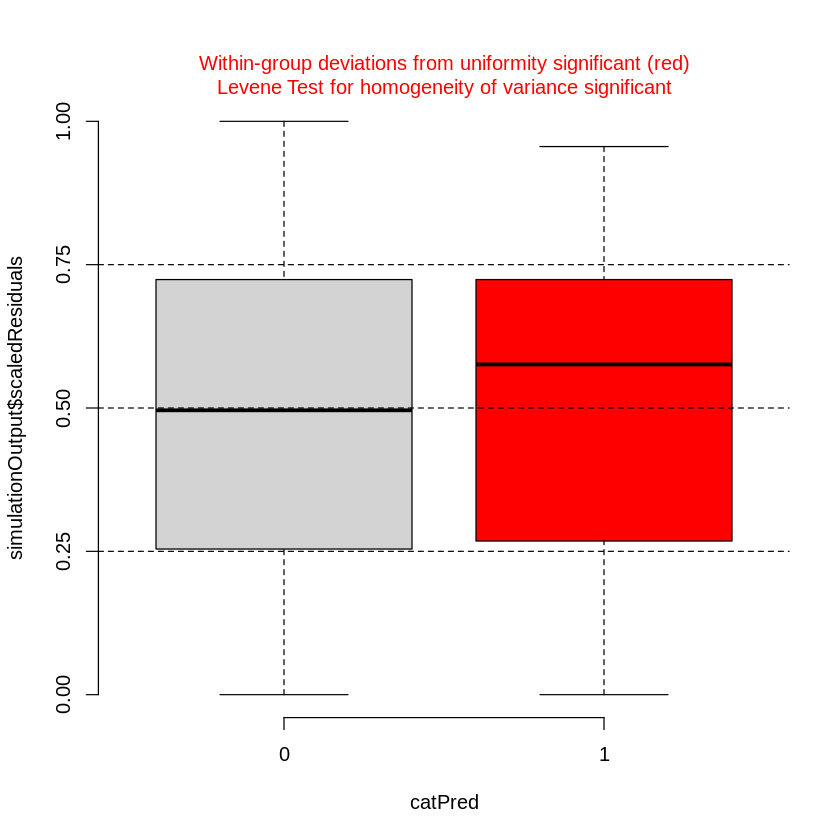

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.035662, p-value = 0.01204
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.08, p-value = 0.1995
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.0120425 0.1995183

$uniformity$p.value.cor
[1] 0.0240850 0.1995183


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value Pr(>F)
group    1  1.1094 0.2923
      2188               


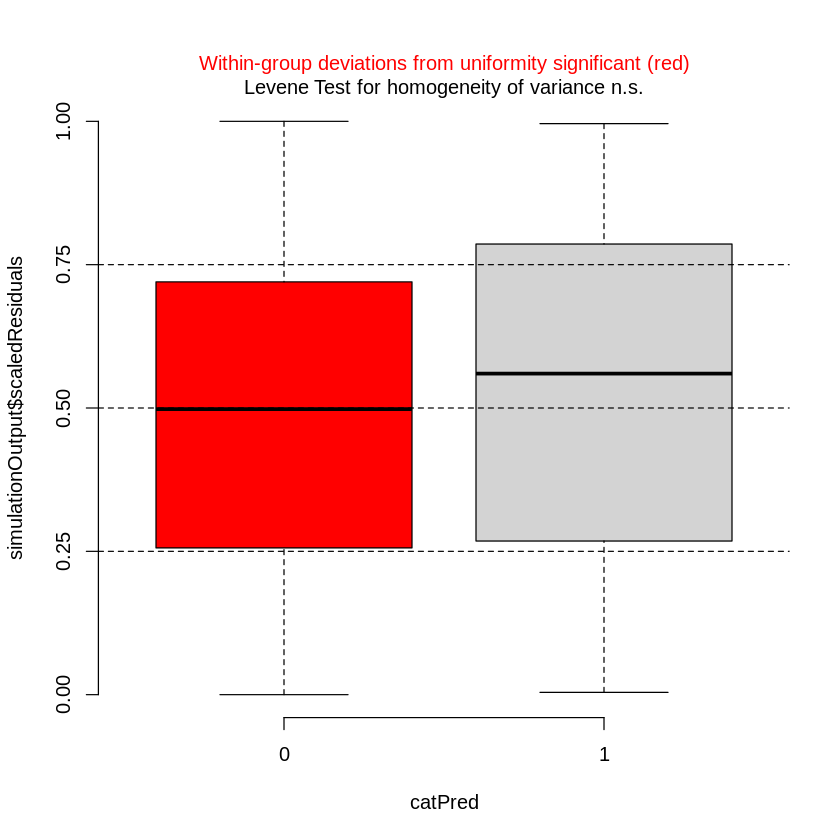

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.036754, p-value = 0.008904
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.10413, p-value = 0.03542
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.008904215 0.035422766

$uniformity$p.value.cor
[1] 0.01780843 0.03542277


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value  Pr(>F)  
group    1  5.7843 0.01625 *
      2188                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


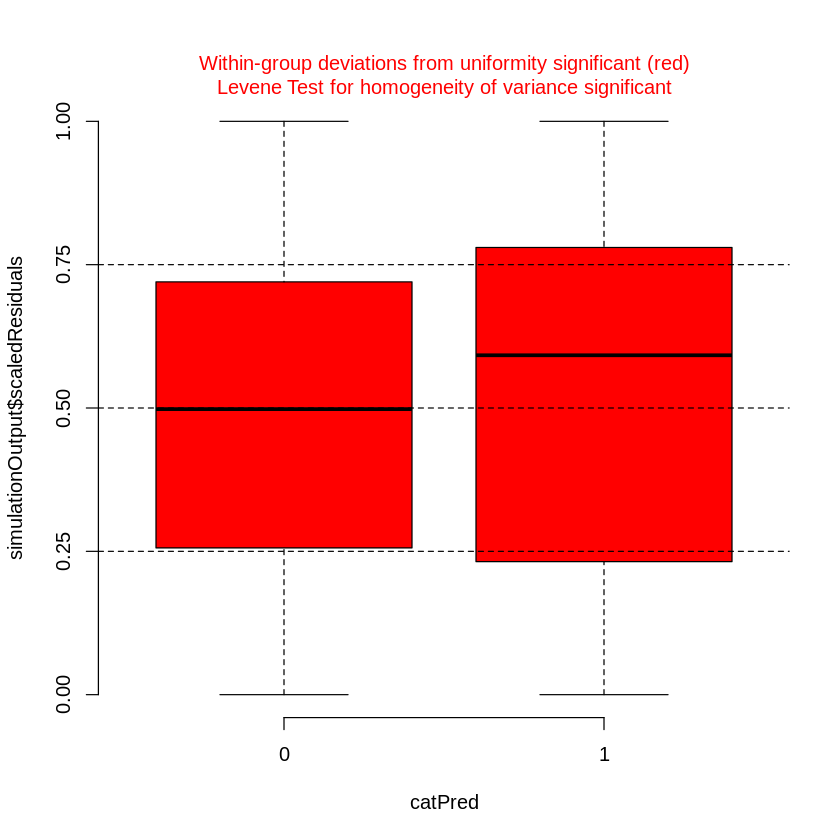

$uniformity
$uniformity$details
catPred: 0

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.023701, p-value = 0.2088
alternative hypothesis: two-sided

------------------------------------------------------------ 
catPred: 1

	Asymptotic one-sample Kolmogorov-Smirnov test

data:  dd[x, ]
D = 0.15489, p-value = 0.000355
alternative hypothesis: two-sided


$uniformity$p.value
[1] 0.2088218409 0.0003549771

$uniformity$p.value.cor
[1] 0.2088218409 0.0007099542


$homogeneity
Levene's Test for Homogeneity of Variance (center = median)
        Df F value   Pr(>F)    
group    1   25.14 5.76e-07 ***
      2188                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


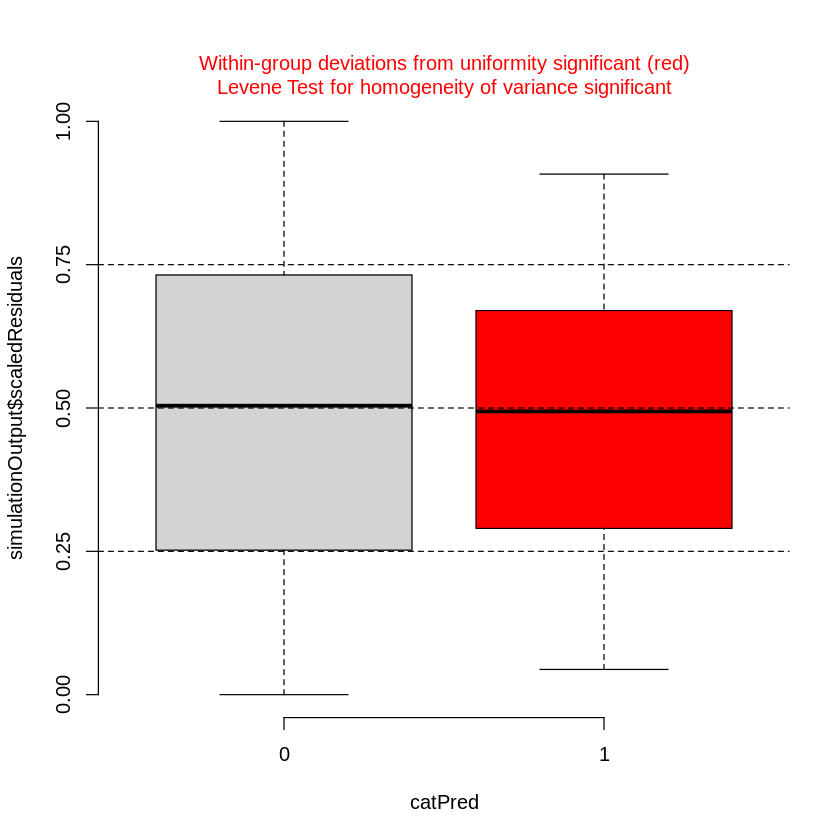

In [ ]:
# test month

testCategorical(simulationOutput, catPred = MT_deterministic_data1$jan[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$feb[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$mar[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$apr[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$mai[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$jun[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$jul[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$aug[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$sep[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$okt[1:2190])
testCategorical(simulationOutput, catPred = MT_deterministic_data1$nov[1:2190])

Warning message in sqrt(diag(x$var.coef)):
“NaNs produced”


Series: res 
Regression with ARIMA(4,1,16) errors 

Coefficients:
         ar1      ar2      ar3      ar4      ma1     ma2      ma3     ma4
      0.0095  -1.2484  -0.0367  -0.2637  -0.3922  1.2020  -0.5353  0.0776
s.e.     NaN   0.4296      NaN   0.3965      NaN  0.5143      NaN  0.4961
          ma5     ma6     ma7      ma8     ma9     ma10     ma11     ma12
      -0.2778  -0.162  0.0413  -0.1142  0.1184  -0.0968  -0.0245  -0.0841
s.e.   0.0635     NaN     NaN   0.0682  0.0529   0.0542   0.0632   0.0244
         ma13     ma14     ma15    ma16        jan        feb       mar
      -0.0145  -0.0436  -0.0083  0.0094  -190.1173  -360.8619  -45.3185
s.e.      NaN   0.0488   0.0108  0.0351   110.7799   141.3343  157.2659
           apr       mai       jun       jul       aug      sep       okt
      318.2297  332.6766  329.4189  538.4639  667.0542  676.181  284.4887
s.e.  170.8600  178.5293  179.3376  177.4646  172.9379  159.699  133.7729
          nov
      16.8285
s.e.  98.0979

sigma^2 =

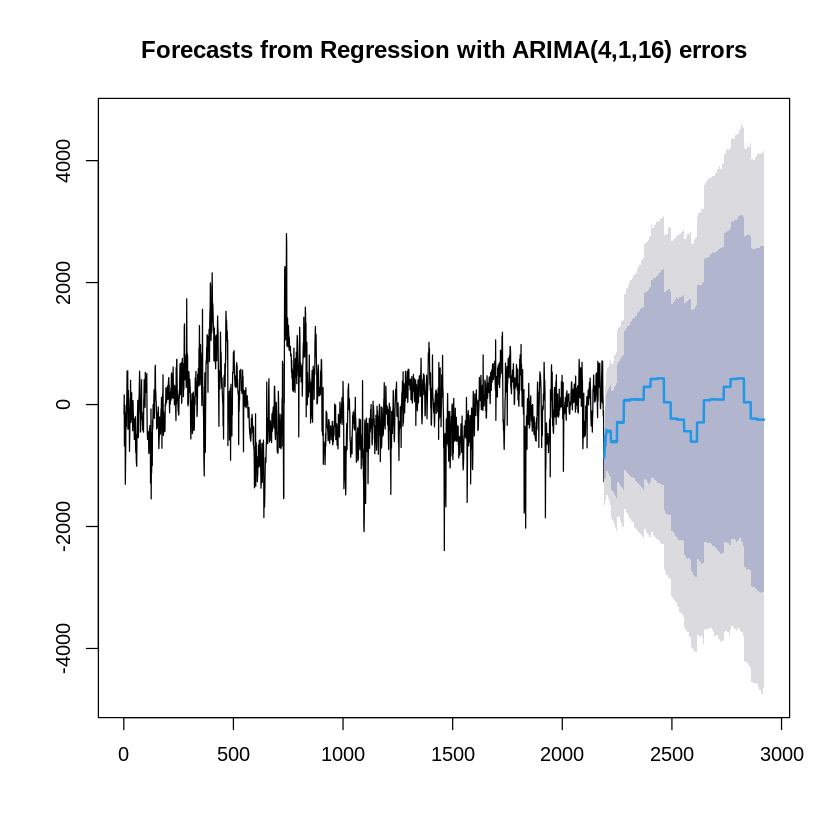

In [ ]:
# -> weekdays seem to be completely accounted for by the deterministic model
#    maybe adding the month as external predictors can improve the forecast

# Try all external predictors and check for significance

grid_model_reg <- Arima(res, order = c(p_order, d, q_order),xreg = as.matrix(MT_deterministic_data1[1:2190,c(18:28)]))
forecasted_arima_reg<-forecast(grid_model_reg, h=730, xreg = as.matrix(MT_deterministic_data1[2191:2920,c(18:28)]) ,biasadj=TRUE,bootstrap = TRUE)
plot(forecasted_arima_reg)
summary(grid_model_reg)

In [ ]:
# Compare with normal ARIMA forecast and GRU1 forecast

forecasted_arima<-forecast(best_model_mid, h=730,biasadj=TRUE,bootstrap = TRUE)

res_forecasted <- forecasted_arima$mean
res_forecasted_gru <-MT_deterministic_data1$gru[2191:2920]
res_forecasted_reg <- forecasted_arima_reg$mean

res_sum_arima <- sum(abs(MT_deterministic_data1$target_residuals[2191:2920] - res_forecasted))
res_sum_arima
res_sum_arima_gru <- sum(abs(MT_deterministic_data1$target_residuals[2191:2920] - res_forecasted_gru))
res_sum_arima_gru
res_sum_arima_reg <- sum(abs(MT_deterministic_data1$target_residuals[2191:2920] - res_forecasted_reg))
res_sum_arima_reg

[1] 338468.7

[1] 294075.4

[1] 337314.5

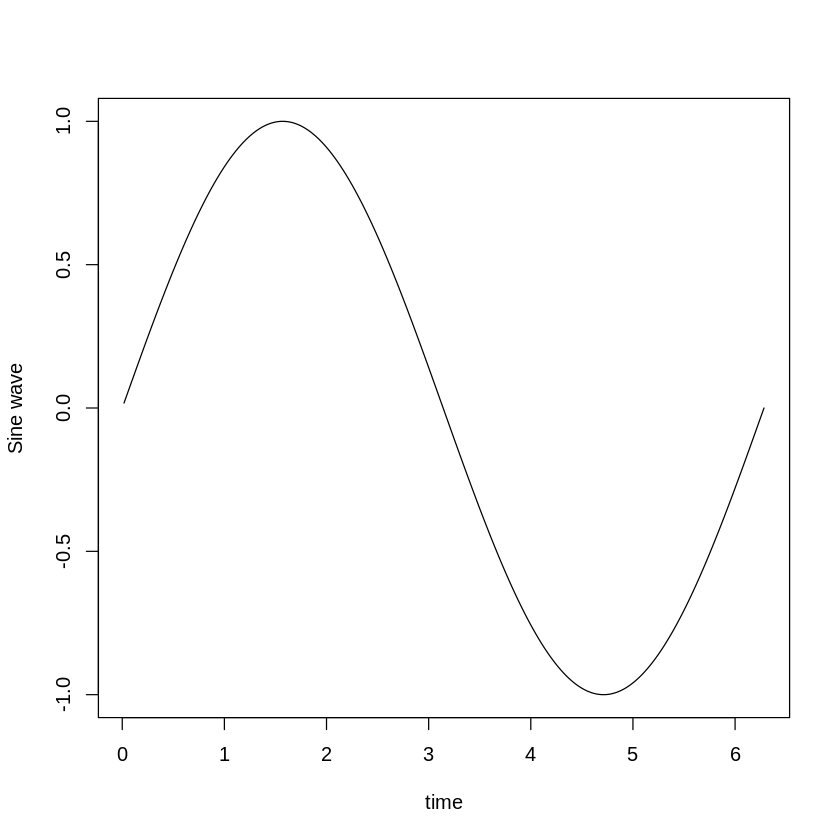

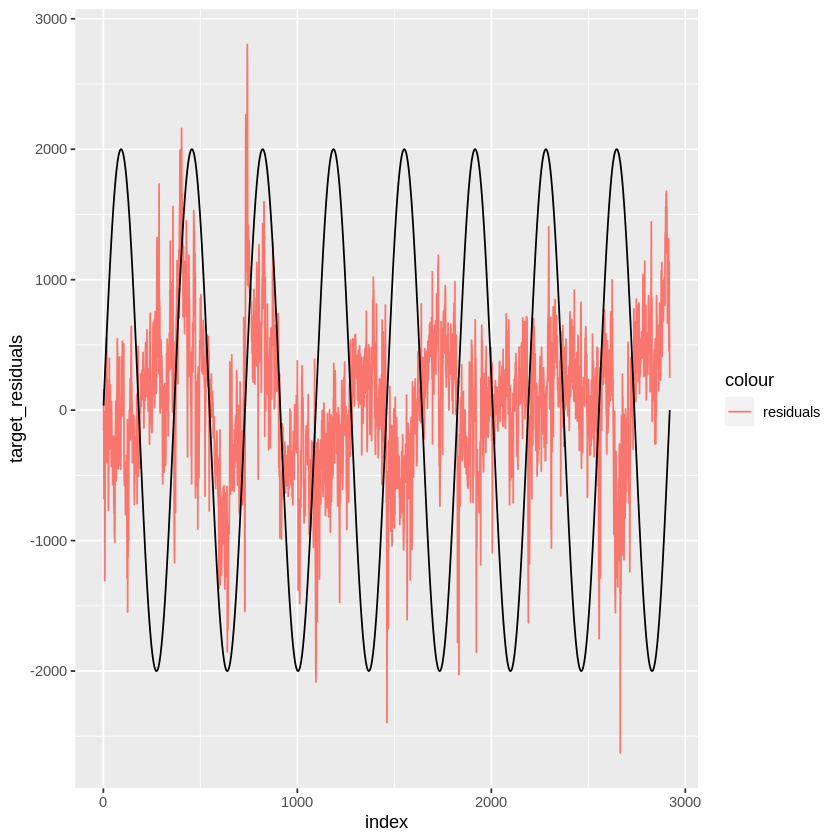

In [ ]:
# --> GRU and ARIMA without external regressors still have a better forecast accuracy/lower residual sum
# Check the residual structure visually and add a yearly sinus

MT_deterministic_data1$index <- 1:nrow(MT_deterministic_data1)

t=seq(0.0172,pi*2,(pi*(2/365)))
yearly_sin <- sin(t)
plot(t,yearly_sin,type="l", xlab="time", ylab="Sine wave")
MT_deterministic_data1$sin <- yearly_sin *2000

library(ggplot2)
res_structure <- ggplot(MT_deterministic_data1[1:2920,])+geom_line(aes(index,target_residuals,color='residuals'))+
                 geom_line(aes(index,sin))
res_structure

In [ ]:
## --> summer time seems to still show a recurring pattern as well as the start of the year
#     summer, autumn and spring month as well as january are added step-wise to see if forecasting accuracy can
#     be improved.

best_model_mid_with_reg <- Arima(res, order = c(p_order, d, q_order),xreg = as.matrix(MT_deterministic_data1[1:2190,c(18,22:27)]))
forecasted_arima_reg2<-forecast(best_model_mid_with_reg, h=730, xreg = as.matrix(MT_deterministic_data1[2191:2920,c(18,22:27)]) ,biasadj=TRUE,bootstrap = TRUE)

res_forecasted_reg <- forecasted_arima_reg2$mean
res_sum_arima_reg <- sum(abs(MT_deterministic_data1$target_residuals[2191:2920] - res_forecasted_reg))
res_sum_arima_reg
res_sum_arima_reg/sum(abs(MT_deterministic_data1$target_residuals[2191:2920]))
res_sum_arima_gru/sum(abs(MT_deterministic_data1$target_residuals[2191:2920]))

[1] 291709.2

[1] 0.9276718

[1] 0.9351965

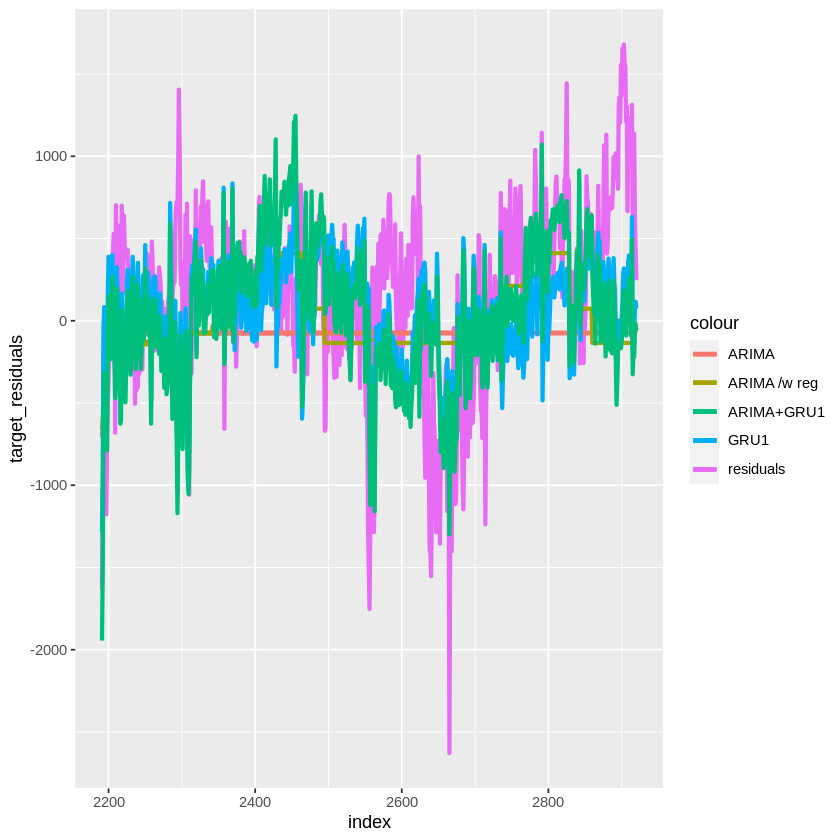

In [ ]:
# Check forecast visually
MT_deterministic_data1$arima_gru <- c(best_model_mid_with_reg$fitted,(res_forecasted_reg+res_forecasted_gru))

res_comparism <- ggplot(MT_deterministic_data1[2191:2920,])+geom_line(aes(index,target_residuals,color='residuals'),lwd=1.2)+
  geom_line(aes(index, res_forecasted,color="ARIMA"),lwd=1.2)+geom_line(aes(index, res_forecasted_reg,color= "ARIMA /w reg"),lwd=1.2)+
  geom_line(aes(index,gru,color="GRU1"),lwd=1.2)+ geom_line(aes(index,arima_gru
                                                                  ,color="ARIMA+GRU1"),lwd=1.2)

res_comparism

In [ ]:
# Save Arima model with regressors

save(best_model_mid_with_reg,file = "final_ARIMA_mid.Rdata")

In [ ]:
###### Save all model results ########

midterm_model_results <- MT_deterministic_data1[,c(1:4,37:39,41:43)]
midterm_model_results$stoch <- c(best_model_mid_with_reg$fitted,res_forecasted_gru)
midterm_model_results$full_model <- midterm_model_results$lm_pred+midterm_model_results$stoch
midterm_model_results$res_full_model <- midterm_model_results$mid_load -midterm_model_results$full_model


write.csv(midterm_model_results,"midterm_model_results.csv",row.names = F)

In [ ]:
###### Plot results ########
# Install the patchwork package
install.packages("patchwork")

# Load the patchwork package
library(patchwork)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# load local library for plotting
library(ggplot2)

In [ ]:
# Define a custom ggplot2 theme (similar to `theme_Publication`)
theme_Publication <- function() {
  theme_minimal() +
    theme(
      text = element_text(size = 18),
      axis.title = element_text(size = 25, face = "bold"),
      plot.title = element_text(size = 30, face = "bold"),
      legend.title = element_blank(),
      legend.text = element_text(size = 18),
      axis.text = element_text(size = 18)
    )
}

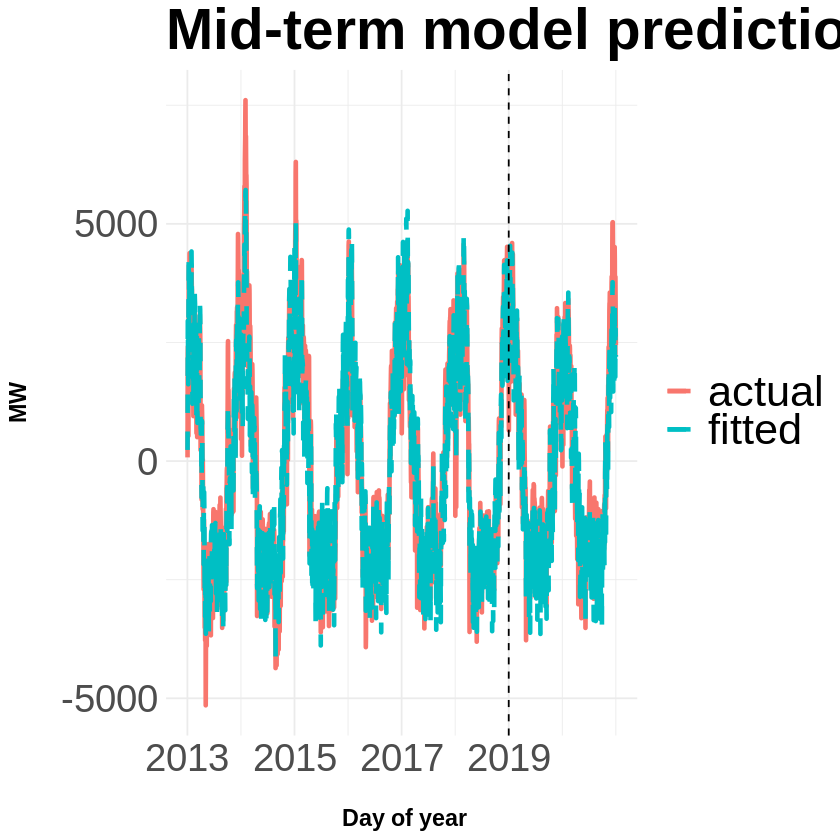

In [ ]:
midterm_model_results <- read.csv("midterm_model_results.csv")


MTplot_overview <- ggplot(midterm_model_results)+geom_line(aes(index,mid_load,color="actual"),lwd=1.3)+
  geom_line(aes(index,lm_pred,color='fitted'),linetype=2,lwd=1.3)+
  geom_vline(xintercept=2190,linetype = 2)+
  xlab("\n Day of year") + ylab("MW\n")+
  ggtitle('Mid-term model predictions')+
  theme_Publication()+ theme(legend.title = element_blank())+
  theme(axis.title=element_text(size=14))+
  theme(legend.text=element_text(size=26))+
  theme(axis.text=element_text(size=23))+
  theme(plot.title = element_text(size=34))+
  scale_x_continuous(breaks=c(0,730,1460 , 2190), labels=c(2013,2015,2017,2019))

MTplot_overview

ggsave(file="MTplot_overview.png", plot=MTplot_overview, width=12, height=8)

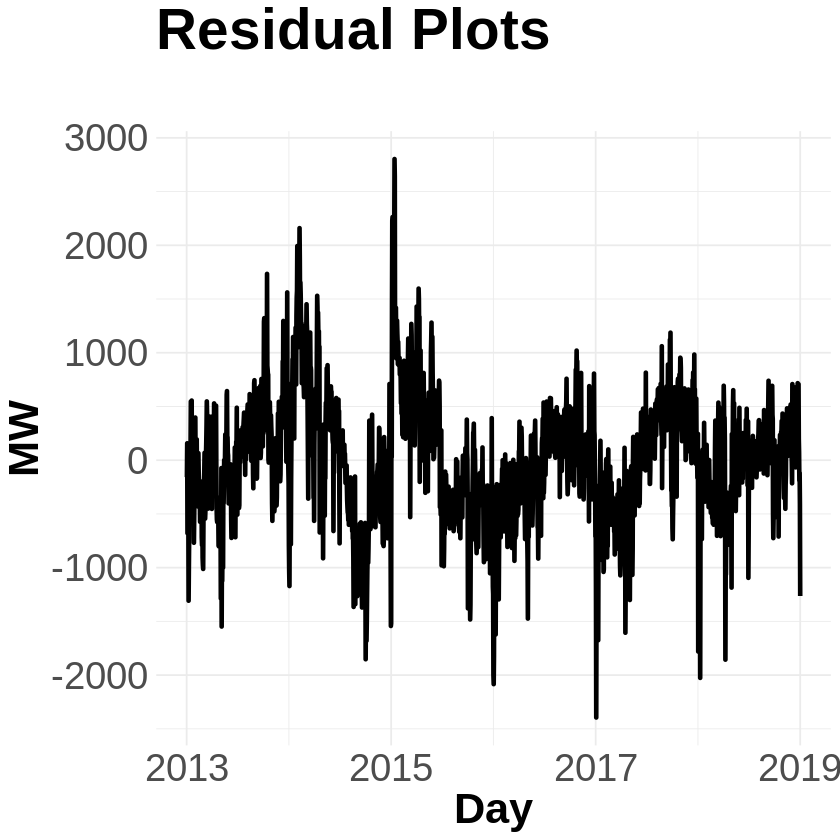

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


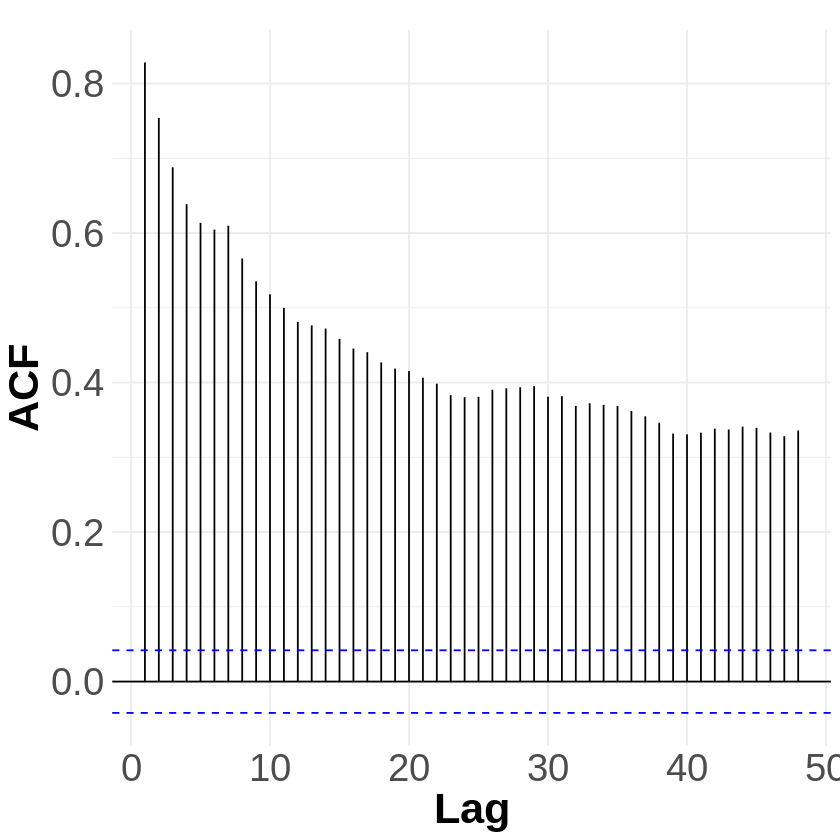

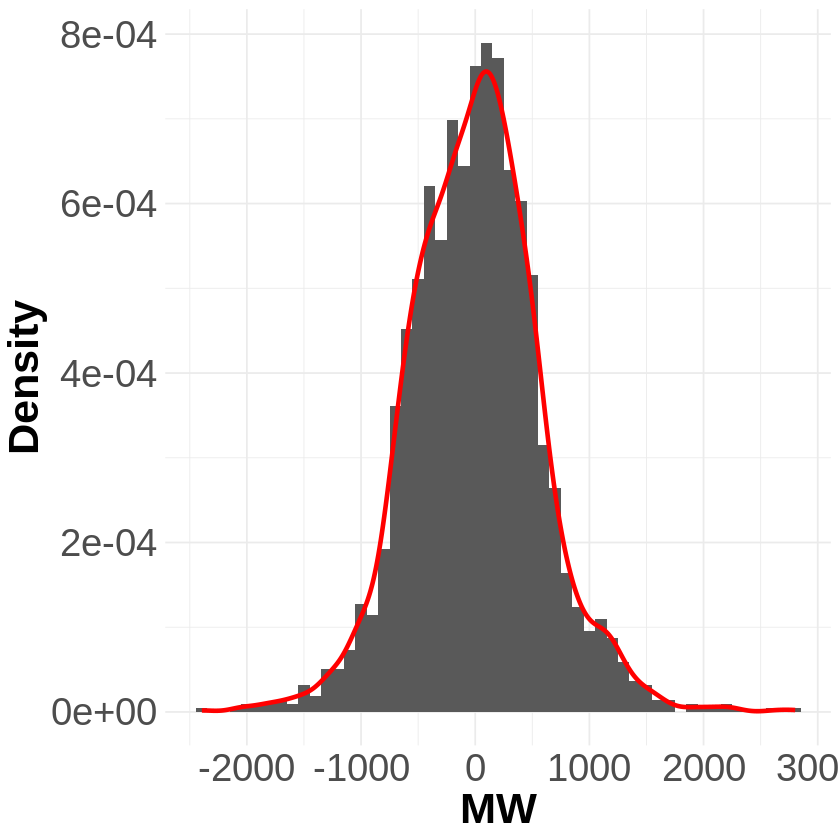

In [ ]:
# Residual plots

MTres1<-ggplot(midterm_model_results[0:2190,]) + geom_line(aes(x = index, y =target_residuals ),lwd=1.3)+
  ggtitle(label = "Residual Plots\n") +theme_Publication()+
  ylab("MW")+xlab("Day")+
  theme(axis.title=element_text(size=26))+
  theme(legend.text=element_text(size=26))+
  theme(axis.text=element_text(size=23))+
  theme(plot.title = element_text(size=34))+
  scale_x_continuous(breaks=c(0,730,1460 , 2190), labels=c(2013,2015,2017,2019))

MTres1

MTres2<-ggAcf(midterm_model_results$target_residuals[1:2190], lag.max = 48)+ theme_Publication() +ggtitle(element_blank())+
  theme(axis.title=element_text(size=26))+
  theme(legend.text=element_text(size=26))+
  theme(axis.text=element_text(size=23))+
  theme(plot.title = element_text(size=34))

MTres2

MTres3<-ggplot(midterm_model_results[1:2190,], aes(x = target_residuals))+geom_histogram(aes(y = ..density..),binwidth = 100) +
  geom_density(color="red",lwd=1.3)+
  theme_Publication()+
  ylab("Density")+xlab("MW")+
  theme(axis.title=element_text(size=26))+
  theme(legend.text=element_text(size=26))+
  theme(axis.text=element_text(size=23))+
  theme(plot.title = element_text(size=34))

MTres3

Warning message:
“Removed 171 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 171 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 171 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 171 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


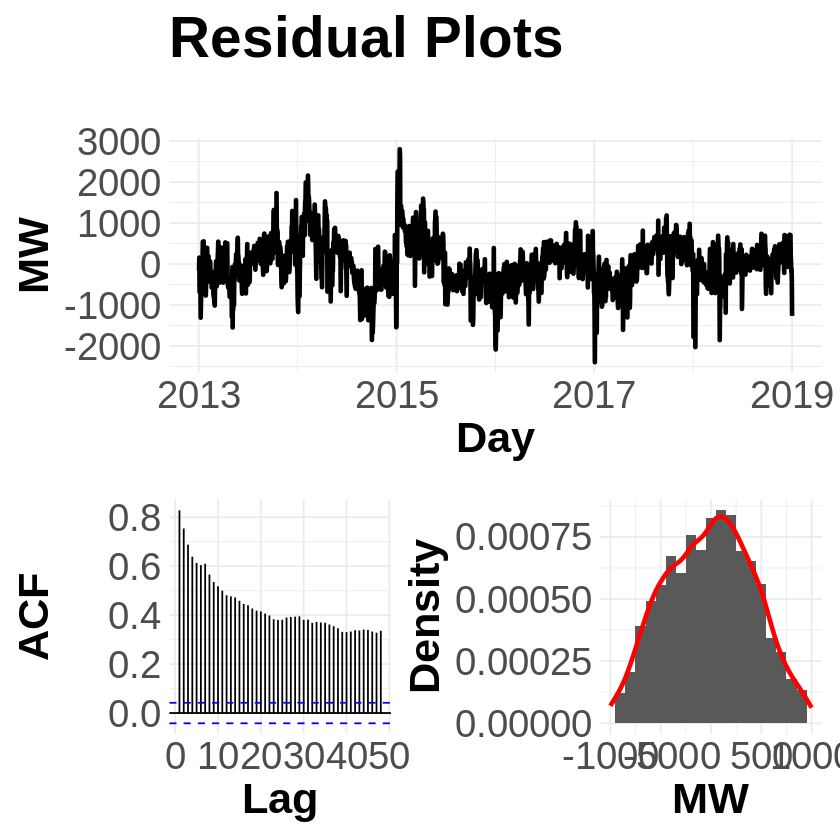

In [ ]:
## Arrange residual plots

MTresiduals<-MTres1 /(MTres2+MTres3)
MTresiduals

ggsave(file="MTplot_residuals.png", plot=MTresiduals, width=12, height=8)